# Facial Keypoint Detection
  
We will define and train a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces.  Firstly we will load and visualize the data. 

Let's take a look at some examples of images and corresponding facial keypoints.

<img src='images/key_pts_example.png' width=50% height=50%/>

We will indicate as facial landmarks dots on faces. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc.

<img src='images/landmarks_numbered.jpg' width=30% height=30%/>

---

## Load and Visualize Data

We will use [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/), which includes videos of people in YouTube videos. Authors fed videos through some automated processing and extracted faces with keypoints on them

#### Training and Testing Data

Dataset consists of 5770 color images.

* 3531 of these images are training images, we will construct model with their help
* 2308 are test images, which will be used to test the accuracy of model.

We will read CSV files using `pandas`. We want to extract landmark coordinates from CSV and put annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y)

---

In [1]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import datetime
import cv2

In [2]:
key_pts_frame = pd.read_csv('data/training_frames_keypoints.csv')

n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

print('Image name: ', image_name)
print('Landmarks shape: ', key_pts.shape)
print('First 4 key pts: {}'.format(key_pts[:4]))

# print out some stats about the data
print('Number of images: ', key_pts_frame.shape[0])

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]
Number of images:  3531


## Look at some images

Helper function `show_keypoints` to display images with landmarks on them.  All images have different number of pixels. So
to train a neural network we have to standardize their shape.

Wes_Craven_02.jpg
(305, 286, 4)


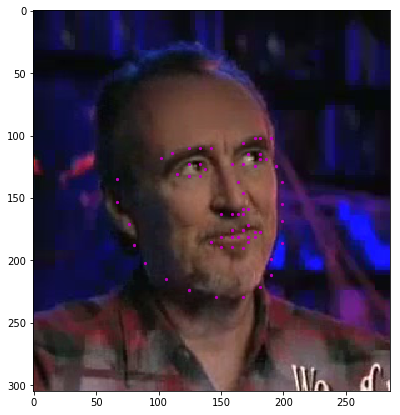

In [3]:
def show_keypoints(image, key_pts):
    position = 0
    print(image.shape)
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

# Display a few different types of images by changing the index n

n = np.random.randint(0, key_pts_frame.shape[0])
image_name = key_pts_frame.iloc[n, 0]
print(image_name)

key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(7, 7))
show_keypoints(mpimg.imread(os.path.join('data/training/', image_name)), key_pts)
#show_keypoints(mpimg.imread(os.path.join('data/faces/', image_name)), key_pts)

plt.show()

## Dataset class and Transformations

#### Dataset class

``torch.utils.data.Dataset`` is an abstract class representing a dataset. This class will allow us to load batches of image/keypoint data, and uniformly apply transformations to our data, such as rescaling and normalizing images for training a neural network.

We will inherit ``Dataset`` and override the following methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get the i-th sample of image/keypoint data.

Let's create a dataset class for our face keypoints dataset. We will read the CSV file in ``__init__`` but leave the reading of images to ``__getitem__``. This is memory efficient because all the images are not stored in the memory at once but read as required.

A sample of our dataset will be a dictionary ``{'image': image, 'keypoints': key_pts}``. Our dataset will take an optional argument ``transform`` so that any required processing can be applied on the sample. We will see the usefulness of `transform`` in the next section.


In [4]:
from torch.utils.data import Dataset, DataLoader

class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        
        image_name = os.path.join(self.root_dir,
                                self.key_pts_frame.iloc[idx, 0])
        #print(image_name)
        image = mpimg.imread(image_name)
        
        # if image has an alpha color channel, get rid of it
        if(image.shape[2] == 4):
            image = image[:,:,0:3]
        
        key_pts = self.key_pts_frame.iloc[idx, 1:].values
        key_pts = key_pts.astype('float').reshape(-1, 2)
        sample = {'image': image, 'keypoints': key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [5]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

#face_dataset = FacialKeypointsDataset(csv_file='data/faces/face_landmarks.csv',
#                                      root_dir='data/faces/')
# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))

Length of dataset:  3531


image index 77
0 (240, 263, 3) (68, 2)
(240, 263, 3)


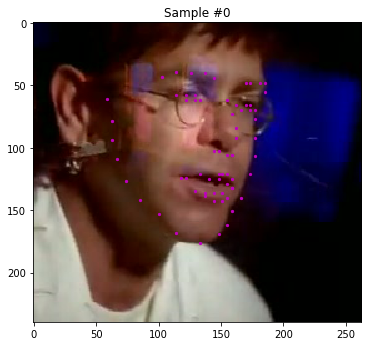

image index 2473
1 (211, 213, 3) (68, 2)
(211, 213, 3)


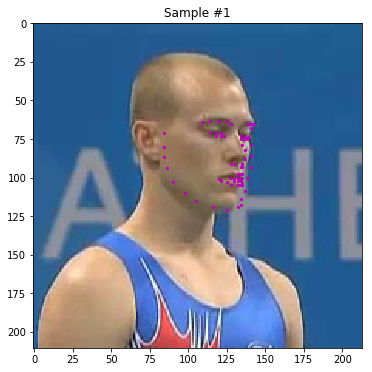

image index 2604
2 (203, 221, 3) (68, 2)
(203, 221, 3)


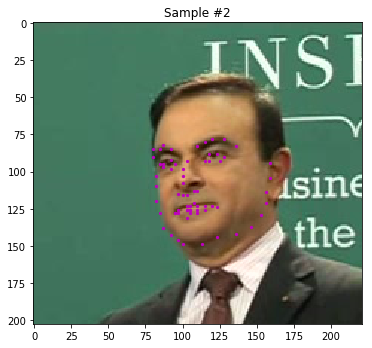

In [6]:
# Display a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):
    fig = plt.figure(figsize=(20,10))
    
    rand_i = np.random.randint(0, len(face_dataset))
    print('image index',rand_i)
    sample = face_dataset[rand_i]
    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['keypoints'].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(i))
    
    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['keypoints'])
    plt.show()


## Transforms

We have to rescale all images to fixed size, normalize color ranges and coordinates, and convert from numpy lists and arrays to Tensors (because Pytorch works with tensors)

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it's called. For this, we just need to implement ``__call__`` method and (if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.



In [7]:
import torch
from torchvision import transforms, utils
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""
    def __init__(self, cropsize, rgb=False):
        assert isinstance(cropsize, int)
        self.cropsize = cropsize


    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0

        s = self.cropsize / 2
        key_pts_copy = (key_pts_copy - s)/s

        return {'image': image_copy, 'keypoints': key_pts_copy}

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size, random_flip=False):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        top_max = min(max(key_pts[:,1].max() - new_h, 0), h - new_h - 1)
        left_max = min(max(key_pts[:,0].max() - new_w, 0), w - new_w - 1)
        top = np.random.randint(top_max, h - new_h)
        left = np.random.randint(left_max, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}
    

class Brightness(object):

    def __init__(self, var=0.8):
        self.var = var

    def __call__(self, sample):
        image1, key_pts = sample['image'], sample['keypoints']
        #h, w = image1.shape
        #print("shape :",image1.shape)

        #param image: Input image
        #return: output image with reduced brightness
       
        if image1.any()<1:
            image1=image1*255

        # convert to HSV so that its easy to adjust brightness
        image1 = cv2.cvtColor(image1,cv2.COLOR_RGB2HSV)
        image1 = np.array(image1, dtype = np.float64)
        random_bright = np.random.uniform(low=self.var, high=1.2)


        image1[:,:,2] = (image1[:,:,2]*random_bright) 
        image1[:,:,2][image1[:,:,2]>255]  = 255
        image1[:,:,2][image1[:,:,2]<0]  = 0
        
        image1 = np.array(image1, dtype = np.uint8)
        image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
        
        return {'image': image1, 'keypoints': key_pts}


class RandomFlip(object):
    """Randomly flip image and keypoints to match"""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        #image1 = np.copy(image)
        #key_pts1 = np.copy(key_pts)
        h, w,_ = image.shape
        if np.random.choice((True, False)):
            image =cv2.flip(image,1)
            key_pts[:,0]=w-key_pts[:,0]
            pairs = [[0, 16], [1, 15], [2, 14], [3, 13], [4, 12], [5, 11], [6, 10],
                 [7, 9], [17, 26], [18, 25], [19, 24], [20, 23], [21, 22], [36, 45],
                 [37, 44], [38, 43], [39, 42], [41, 46], [40, 47], [31, 35], [32, 34],
                 [50, 52], [49, 53], [48, 54], [61, 63], [60, 64], [67, 65], [59, 55], [58, 56]]
            
            for matched_p in pairs:

                idx1, idx2 = matched_p[0], matched_p[1]
                tmp = np.copy(key_pts[idx1])
                key_pts[idx1] =np.copy(key_pts[idx2])
                key_pts[idx2] =tmp
            
        return {'image': image, 'keypoints': key_pts}   

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. As you look at each transform, note that, in this case, **order does matter**. For example, you cannot crop a image using a value smaller than the original image (and the orginal images vary in size!), but, if you first rescale the original image, you can then crop it to any size smaller than the rescaled size.

(224, 224, 3)


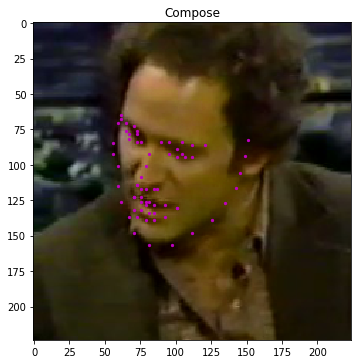

(224, 224, 3)


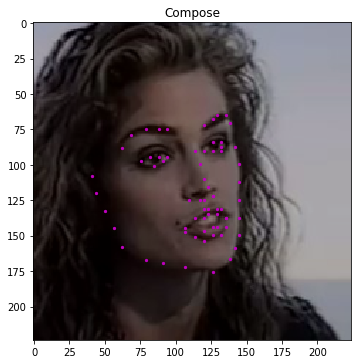

(224, 224, 3)


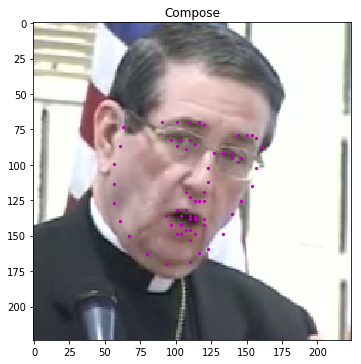

In [14]:
scalesize = 250
cropsize = 224

# We scale all images to scalesize and then randomly crop 224x224 square.
composed = transforms.Compose([Rescale(scalesize),RandomCrop(cropsize),RandomFlip(),Brightness(0.7)])

for w in range(3):
    test_num = np.random.randint(0, key_pts_frame.shape[0])
    sample = face_dataset[test_num]
    fig = plt.figure(figsize=(10,5))

    for i, tx in enumerate([composed]):
        transformed_sample = tx(sample)
        ax = plt.subplot(1, len([composed]), i + 1)
        plt.tight_layout()
        ax.set_title(type(tx).__name__)
        show_keypoints(transformed_sample['image'], transformed_sample['keypoints'])

    plt.show()

## Create the transformed dataset

Apply the transforms in order to get grayscale images of the same shape. Verify that your transform works by printing out the shape of the resulting data (printing out a few examples should show you a consistent tensor size).

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [15]:
scalesize = 250
cropsize = 224

train_transform = transforms.Compose([
                                     Rescale(scalesize),#250,136
                                     RandomCrop(cropsize),#224,96
                                     RandomFlip(),
                                     Normalize(cropsize),
                                     ToTensor()
                                    ])

test_transform = transforms.Compose([ 
                                     Rescale(scalesize),#250,136
                                     RandomCrop(cropsize),#224,96
                                     RandomFlip(),
                                     Normalize(cropsize),
                                     ToTensor()])
assert(train_transform is not None), 'Define a data_transform'
assert(test_transform is not None), 'Define a data_transform'


In [16]:
# create the transformed dataset
train_transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=train_transform)


print('Number of images: ', len(train_transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = train_transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())


Number of images:  3531
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Data Iteration and Batching

So we itertate over images and labels. Let's add PyTorch's dataset capabilities:

-  Batch the data
-  Shuffle the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these

## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [17]:
# load training data in batches
train_batch_size = 64#10

train_loader = DataLoader(train_transformed_dataset, 
                          batch_size=train_batch_size,
                          shuffle=True, 
                          num_workers=0)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [18]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_transformed_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=test_transform)

print('Number of images: ', len(test_transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = test_transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  770
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


In [19]:
# load test data in batches
test_batch_size = 10

test_loader = DataLoader(test_transformed_dataset, 
                          batch_size=test_batch_size,
                          shuffle=True, 
                          num_workers=0)

## Ready to Train!

Now that you've seen how to load and transform our data, you're ready to build a neural network to train on this data.


## Define the Convolutional Neural Network

Ok, we played with Dataset, built loaders.

Now we will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---

## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers
* Batch normalization layers
* Dropout layers

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

In [20]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torchvision import transforms, utils,models
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # We want NN take greyscale image of 224x224 
        # And output through linear layer 68*2=136 numbers which are landmark values
        # input have to be tensor torch.Size([1, 224, 224]) and output is tensor torch.Size([68, 2])

        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 40, 5)
        self.conv2_bn = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 64, 4)
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv4_drop = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(11*11*128, 5000)
        self.fc1_drop = nn.Dropout(p=0.3)
        self.fc2 = nn.Linear(5000, 136)

    def forward(self, x):

        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv1_bn(x)
        out1 = F.relu(x)

        x = self.conv2(out1)
        x = self.pool(x)
        x = self.conv2_bn(x)
        out2 = F.relu(x)

        x = self.conv3(out2)
        x = self.pool(x)
        x = self.conv3_bn(x)
        out3 = F.relu(x)

        x = self.conv4(out3)
        x = self.pool(x)
        x = self.conv4_bn(x)
        out4 = F.relu(x)
        x = self.conv4_drop(out4)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc1_drop(x)
        x = self.fc2(x)

        # a modified x, having gone through all the layers of your model, should be returned
        return x,out1,out2,out3,out4 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=15488, out_features=5000, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=5000, out_features=136, bias=True)
)


In [22]:
print(device)

cuda:0


## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [23]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        #print(type(images))
        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)
        #images = images.to(device)

        key_pts = key_pts.type(torch.cuda.FloatTensor)

        # forward pass to get net output
        output_pts,out1,out2,out3,out4 = net.forward(images.to(device))
        #print(out1.data.size())
        feature_map = [out1,out2,out3,out4]
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts,feature_map
            

In [24]:
test_images, test_outputs, gt_pts,feature_map = net_sample_output()

## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

`show_all_keypoints` function displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [25]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Here is helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

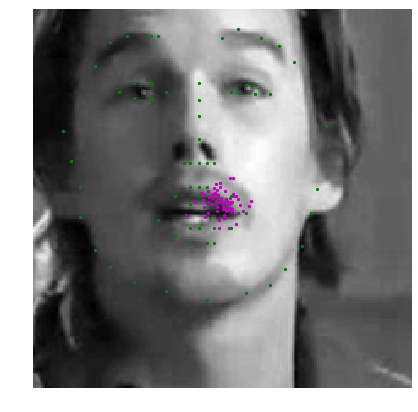

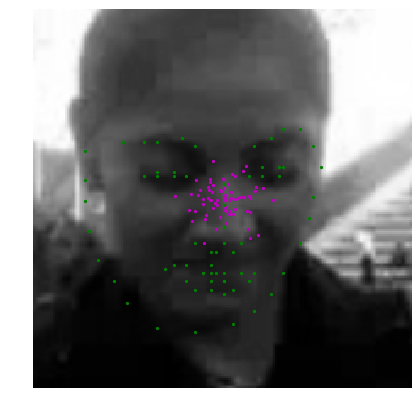

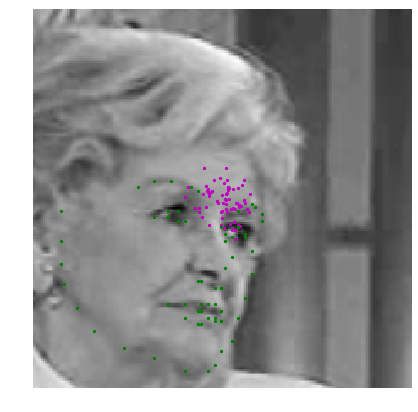

In [26]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=3):

    for i in range(batch_size):
        plt.figure(figsize=(80,50))
        ax = plt.subplot(1, 10, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        #image = image.numpy()   # convert to numpy array from a Tensor
        image = image.cpu().numpy()  #for GPU to CPU
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        #predicted_key_pts = predicted_key_pts.numpy()
        predicted_key_pts = predicted_key_pts.cpu().numpy()

        # undo normalization of keypoints
        mean  = cropsize/2#50#100,50
        std = cropsize/2#15#50,15
        predicted_key_pts = predicted_key_pts*std+mean
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*std+mean
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

We will define loss as MSE loss. Since we're solving regression task and interested to penalize large deviations from ground truth.
Also we choose ADAM optimizer as most popular one

---

In [42]:
import torch.optim as optim

learning_rate = 0.00015
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

#optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

## Training and Initial Observation

Now, let's train on batched training data from `train_loader` for a number of epochs. 

In [43]:

def train_net(n_epochs):

    # prepare the net for training
    net.train()
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0
        batch_num = 0
        start_t = time.time()

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            
            batch_num += 1
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            #output_pts = net(images)
            output_pts,_,_,_,_ = net.forward(images.to(device))#.to(device) is for using GPU

            # calculate the loss between predicted and target keypoints
            #loss = criterion(output_pts, key_pts)
            loss = criterion(output_pts, key_pts.to(device))#.to(device) is for using GPU

            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            running_loss += loss.item()
        
        
        # Model in inference mode, dropout is off. Let's calculate test accuracy
        net.eval()

        accuracy = 0
        test_loss = 0
        #for ii, (images, labels) in enumerate(testloader):
        for batch_it, data_it in enumerate(test_loader):
            # get sample data: images and ground truth keypoints
            images = data_it['image']
            key_pts = data_it['keypoints']

            # convert images to FloatTensors
            images = images.type(torch.FloatTensor)
            key_pts = key_pts.type(torch.FloatTensor)

            # forward pass to get net output
            output_pts,_,_,_,_ = net.forward(images.to(device))

            # reshape to batch_size x 68 x 2 pts
            output_pts = output_pts.view(output_pts.size()[0], 68, -1)
            loss = criterion(output_pts, key_pts.to(device))
            
            # to convert loss into a scalar and add it to the running_loss, use .item()
            test_loss += loss.item()

        train_avg_loss=running_loss
        test_avg_loss = test_loss
        print("Epoch: {}/{}.. ".format(epoch+1, n_epochs),
              "Training Loss: {:.5f}.. ".format(train_avg_loss),
              "Test Loss: {:.5f}.. ".format(test_avg_loss),
              #"Test Accuracy: {:.3f}".format(accuracy/len(testloader))
                 )
        train_avgloss_list.append(train_avg_loss)
        test_avgloss_list.append(test_avg_loss)

        running_loss = 0

        # After calculating test accuracy switch to train mode (dropout on, gradients are calculated)
        net.train()

                
        time_cost = time.time() - start_t
        print("1 Epoch time cost {:.3f}".format(time_cost))
        

    save_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

    model_dir = 'saved_models/'
    model_name = save_time+'_keypoints_model_'+'epoch_'+str(epoch)+'_totale_'+str(n_epochs)+'_'+str(train_batch_size)+'_l_'+str(learning_rate)+'.pt'
    print(model_name)
    # after training, save your model parameters in the dir 'saved_models'
    torch.save(net.state_dict(), model_dir+model_name)

    print('Finished Training')

In [44]:
# train your network
n_epochs = 40 # the bigger the better but learning rate to be scheduled

train_avgloss_list =[]
test_avgloss_list =[]

start_t = time.time()

train_net(n_epochs)

time_cost = time.time() - start_t
print("Total time cost",time_cost)

net.eval()

Epoch: 1/40..  Training Loss: 0.24497..  Test Loss: 0.19455.. 
1 Epoch time cost 21.149
Epoch: 2/40..  Training Loss: 0.26613..  Test Loss: 0.14535.. 
1 Epoch time cost 21.026
Epoch: 3/40..  Training Loss: 0.24676..  Test Loss: 0.24050.. 
1 Epoch time cost 20.981
Epoch: 4/40..  Training Loss: 0.27305..  Test Loss: 0.24033.. 
1 Epoch time cost 20.871
Epoch: 5/40..  Training Loss: 0.18743..  Test Loss: 0.14708.. 
1 Epoch time cost 20.839
Epoch: 6/40..  Training Loss: 0.24873..  Test Loss: 0.24423.. 
1 Epoch time cost 21.019
Epoch: 7/40..  Training Loss: 0.21691..  Test Loss: 0.28886.. 
1 Epoch time cost 20.920
Epoch: 8/40..  Training Loss: 0.24809..  Test Loss: 0.50688.. 
1 Epoch time cost 20.863
Epoch: 9/40..  Training Loss: 0.26441..  Test Loss: 0.23377.. 
1 Epoch time cost 20.838
Epoch: 10/40..  Training Loss: 0.22756..  Test Loss: 0.14880.. 
1 Epoch time cost 20.855
Epoch: 11/40..  Training Loss: 0.24533..  Test Loss: 0.12909.. 
1 Epoch time cost 20.782
Epoch: 12/40..  Training Loss:

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=15488, out_features=5000, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=5000, out_features=136, bias=True)
)

In [31]:
# or you can use trained model which is good enough
net.load_state_dict(torch.load('saved_models/'+'good_model.pt'))
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=15488, out_features=5000, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=5000, out_features=136, bias=True)
)

## Test data

See how your model performs on previously unseen, test data. Let's run trained model on these images to see what kind of keypoints are produced.

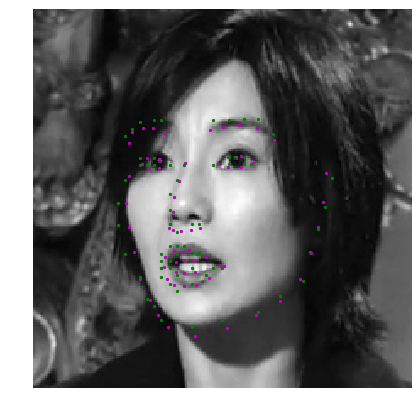

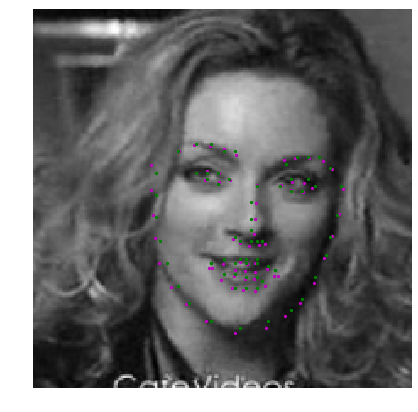

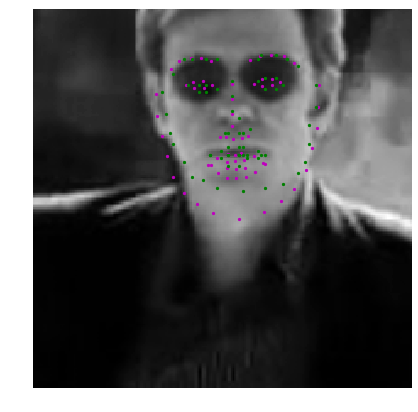

In [45]:
# get a sample of test data again
test_images, test_outputs, gt_pts,feature_map = net_sample_output()
visualize_output(test_images, test_outputs, gt_pts)

In [46]:
print("Our model: \n\n", net, '\n')
print("The state dict keys: \n\n", net.state_dict().keys())

Our model: 

 Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 40, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(40, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4_drop): Dropout(p=0.3)
  (fc1): Linear(in_features=15488, out_features=5000, bias=True)
  (fc1_drop): Dropout(p=0.3)
  (fc2): Linear(in_features=5000, out_features=136, bias=True)
) 

The state dict keys: 

 odict_keys(['conv1.weight', 'conv1.bias', 'conv1_bn.weight'

In [47]:
# after training, save your model parameters in the dir 'saved_models'
# torch.save(net.state_dict(), model_dir+model_name)

#Later to restore:
# nnet = Net()
# nnet.load_state_dict(torch.load(filepath))
# nnet.eval()

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

(32, 1, 5, 5)
[[-9.16319623e-05 -8.75405148e-02 -5.68121411e-02 -1.50673777e-01
   1.01258464e-01]
 [ 5.85335903e-02  1.80758089e-01  9.60232839e-02  9.68475789e-02
  -1.38631940e-01]
 [-1.80135265e-01 -1.75328538e-01 -1.91008747e-01  1.51139125e-01
  -1.16710521e-01]
 [-4.74712253e-02 -2.21527815e-01  9.96021088e-03 -1.53193519e-01
  -6.62973076e-02]
 [ 1.99441403e-01 -1.08796723e-01 -3.82511131e-02 -1.10014319e-01
   1.73500419e-01]]
(5, 5)


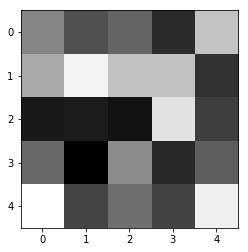

First convolutional layer


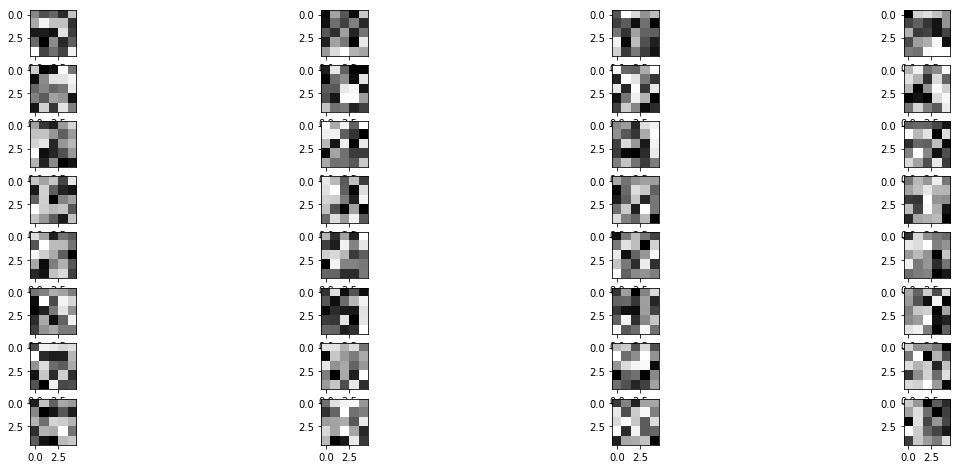

In [48]:

######################
# show conv1 
#######################
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

#w = weights1.numpy()
w = weights1.cpu().numpy()

filter_index = 0
print(w.shape)
print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')
plt.show()


#show the filter
filters,_,fw,fh = w.shape

fig=plt.figure(figsize=(20, 8))
columns = 4
rows = 8
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### Filter an image to see the effect of a convolutional kernel
---

In [49]:
###############
# feature map conv1
###############
def show_feature(layer,rows,culs):
    
    ori_img = test_images[0].data.cpu().numpy()
    print(ori_img.shape)
    plt.imshow(ori_img[0],cmap='gray')
    plt.show()


    fmap = feature_map[layer].data.cpu().numpy()
    print(fmap.shape)

    num_img = fmap.shape[0]
    num_feature = fmap.shape[1]


    #for i in range(num_img):
    for i in range(1):
        fig=plt.figure(figsize=(50, 50))

        for j in range(num_feature):

            img = fmap[i][j]
            #print(img.shape)
            #print(roi.shape)
            #plt.figure()
            fig.add_subplot(rows, culs, j+1)

            plt.imshow(img,cmap='gray')
        plt.show()
        


(1, 224, 224)


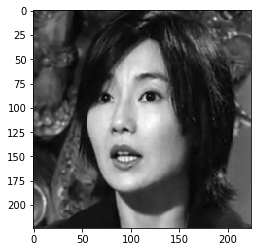

(10, 32, 110, 110)


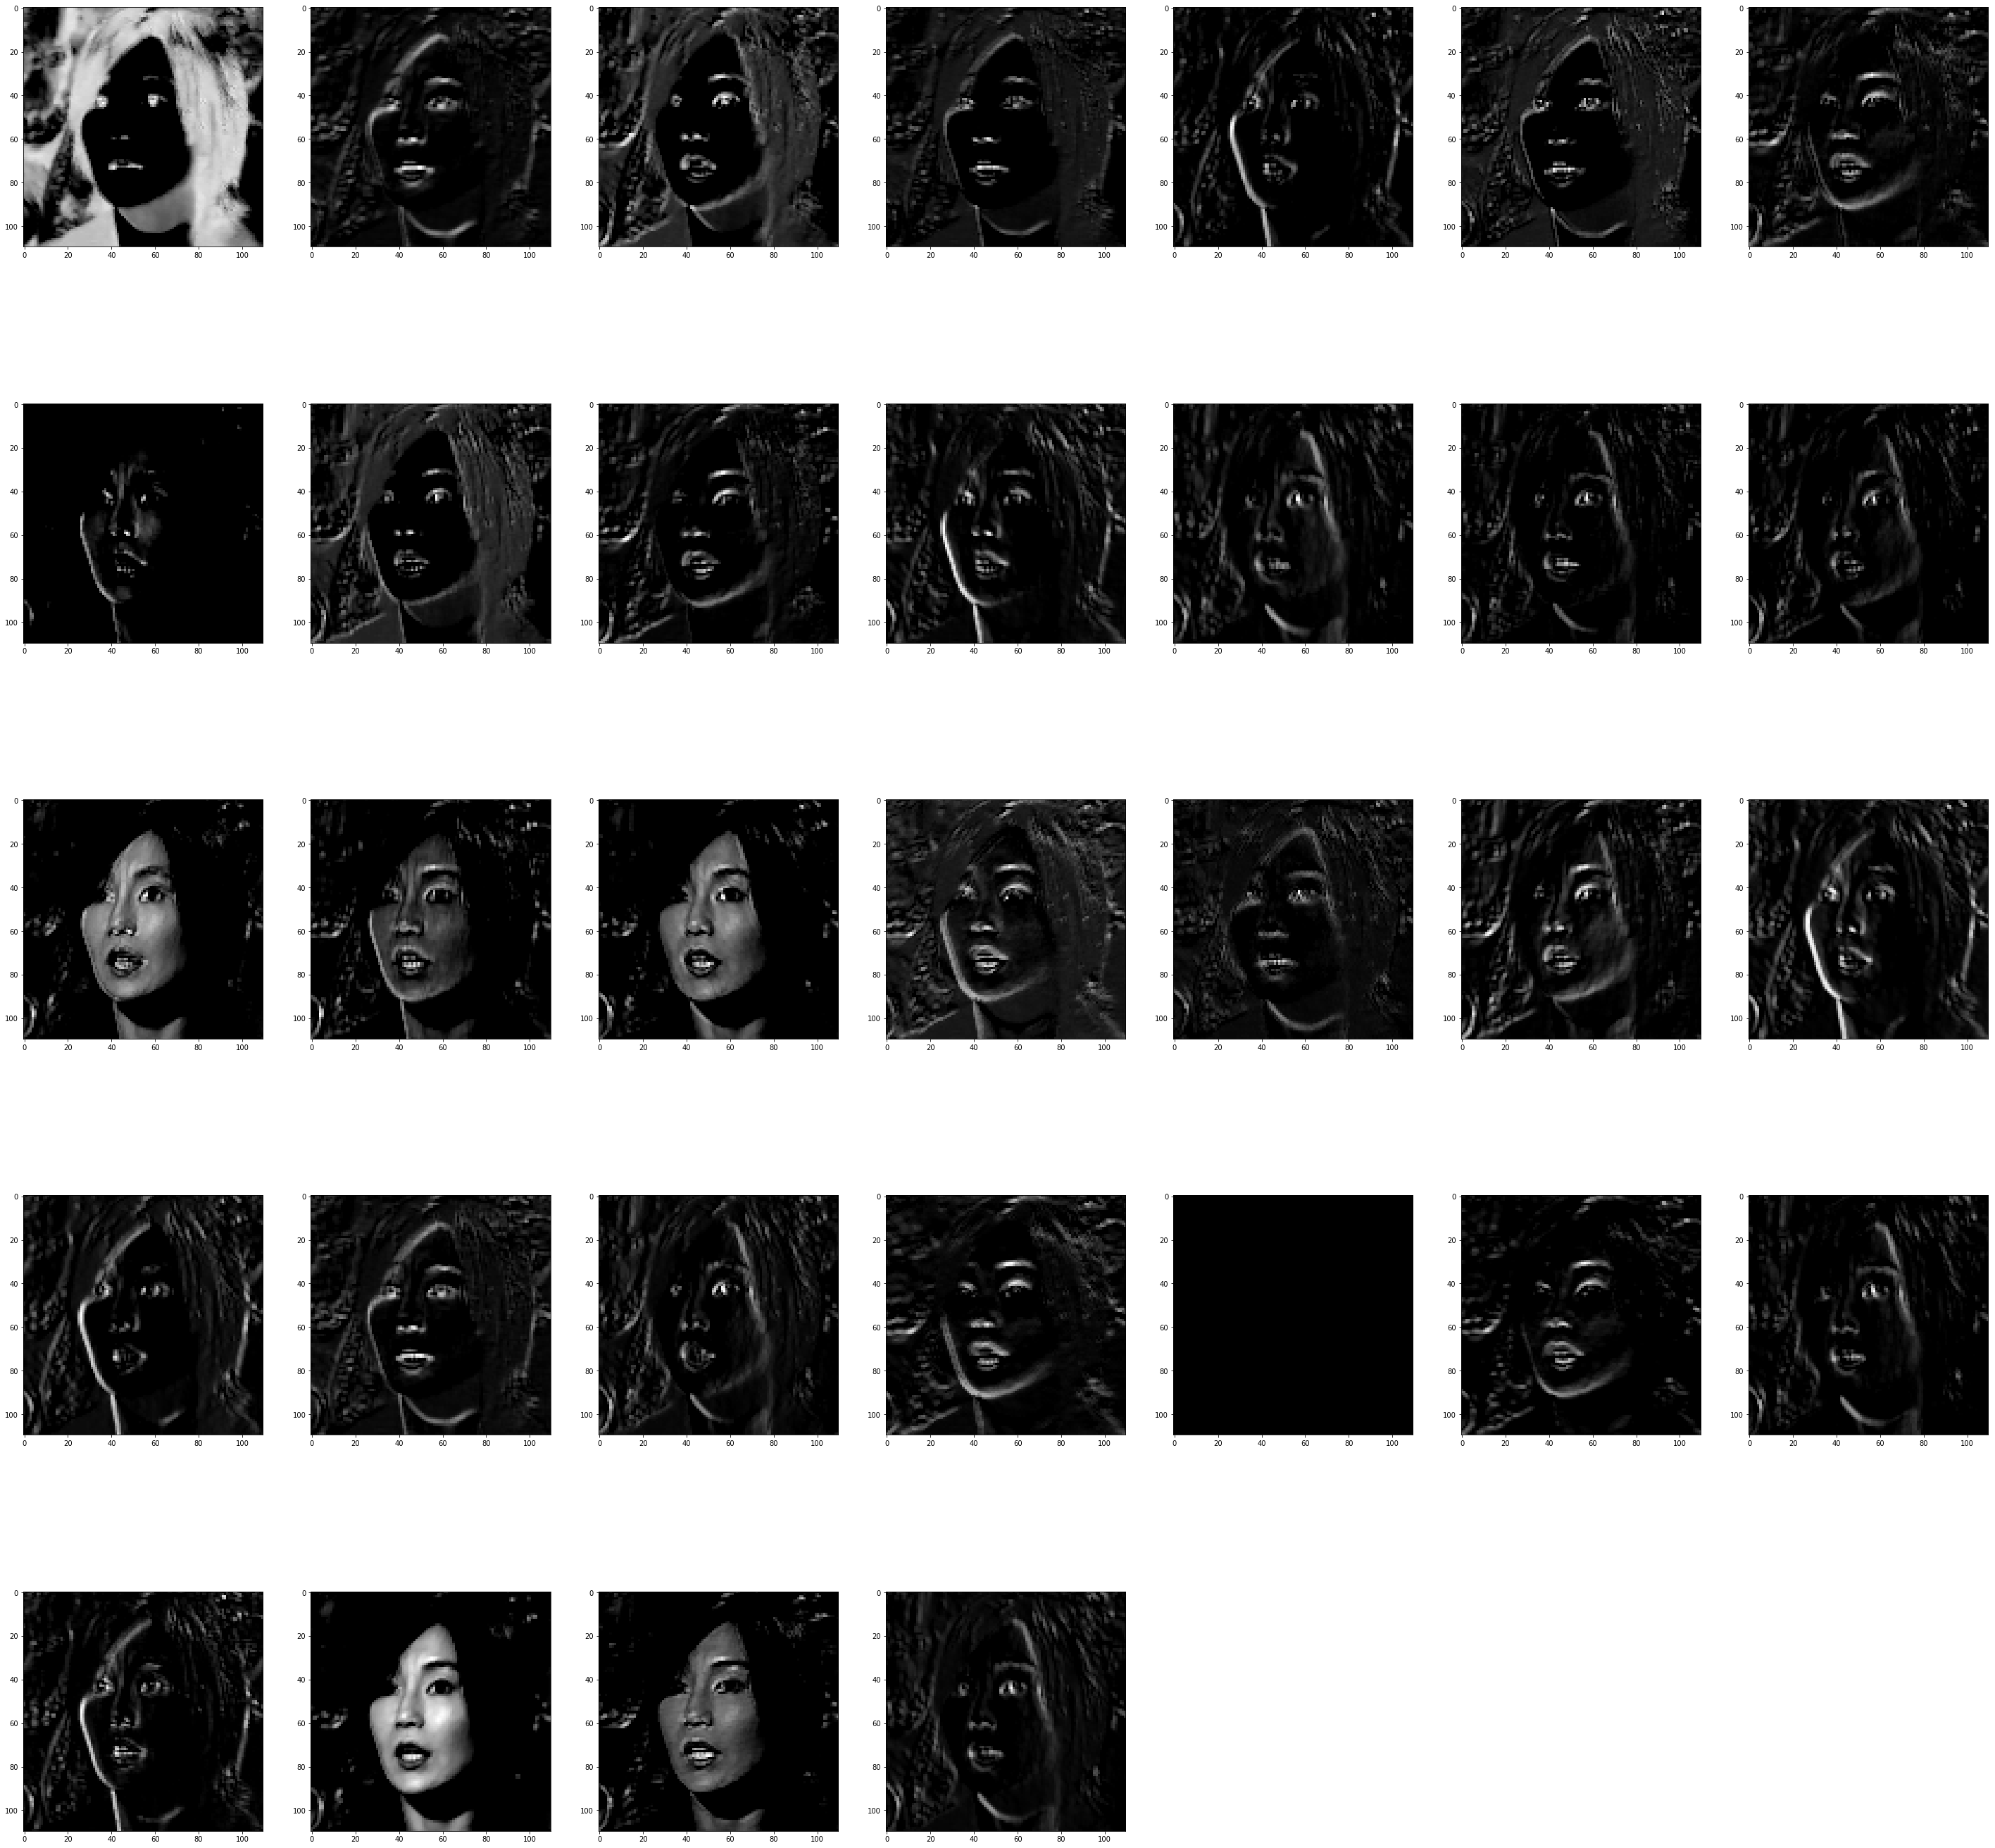

In [50]:
#conv1
show_feature(0,5,7)

(1, 224, 224)


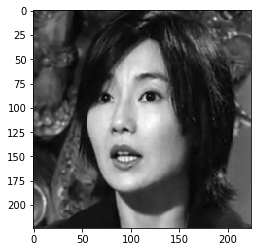

(10, 40, 53, 53)


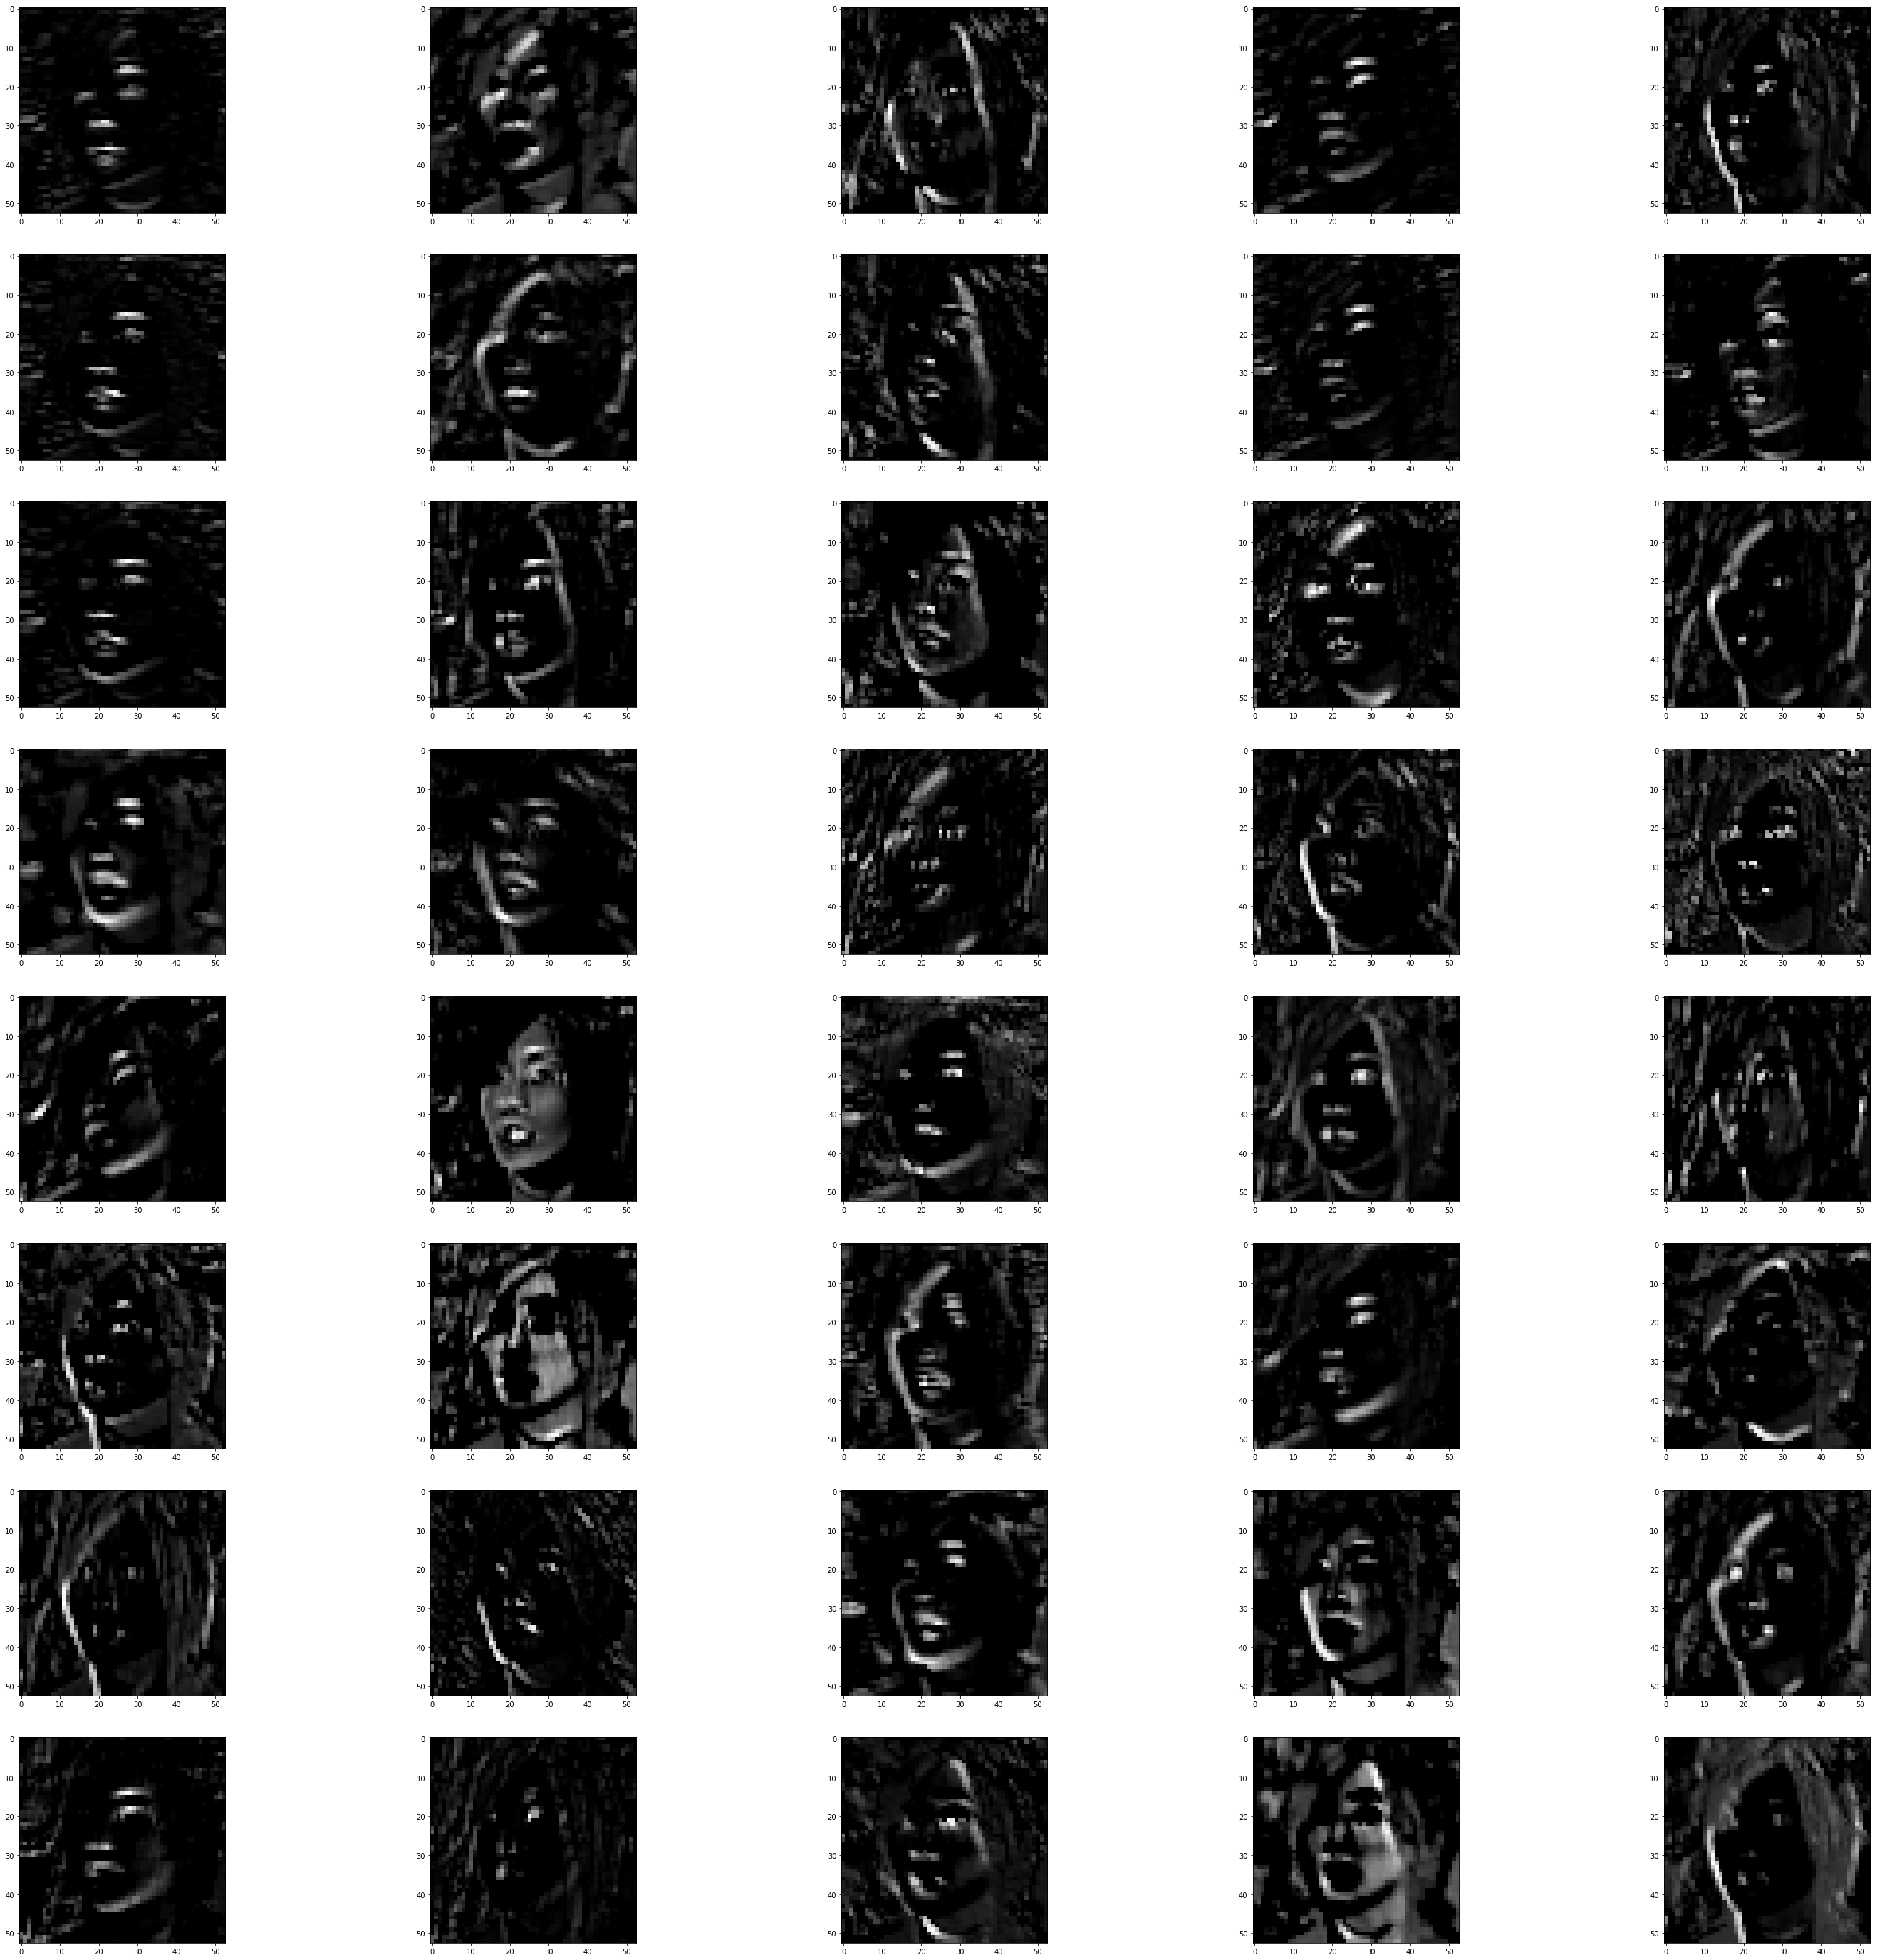

In [51]:
#conv2
show_feature(1,8,5)

(1, 224, 224)


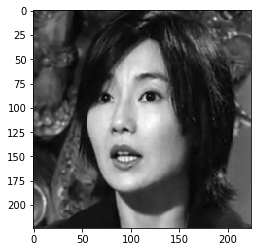

(10, 64, 25, 25)


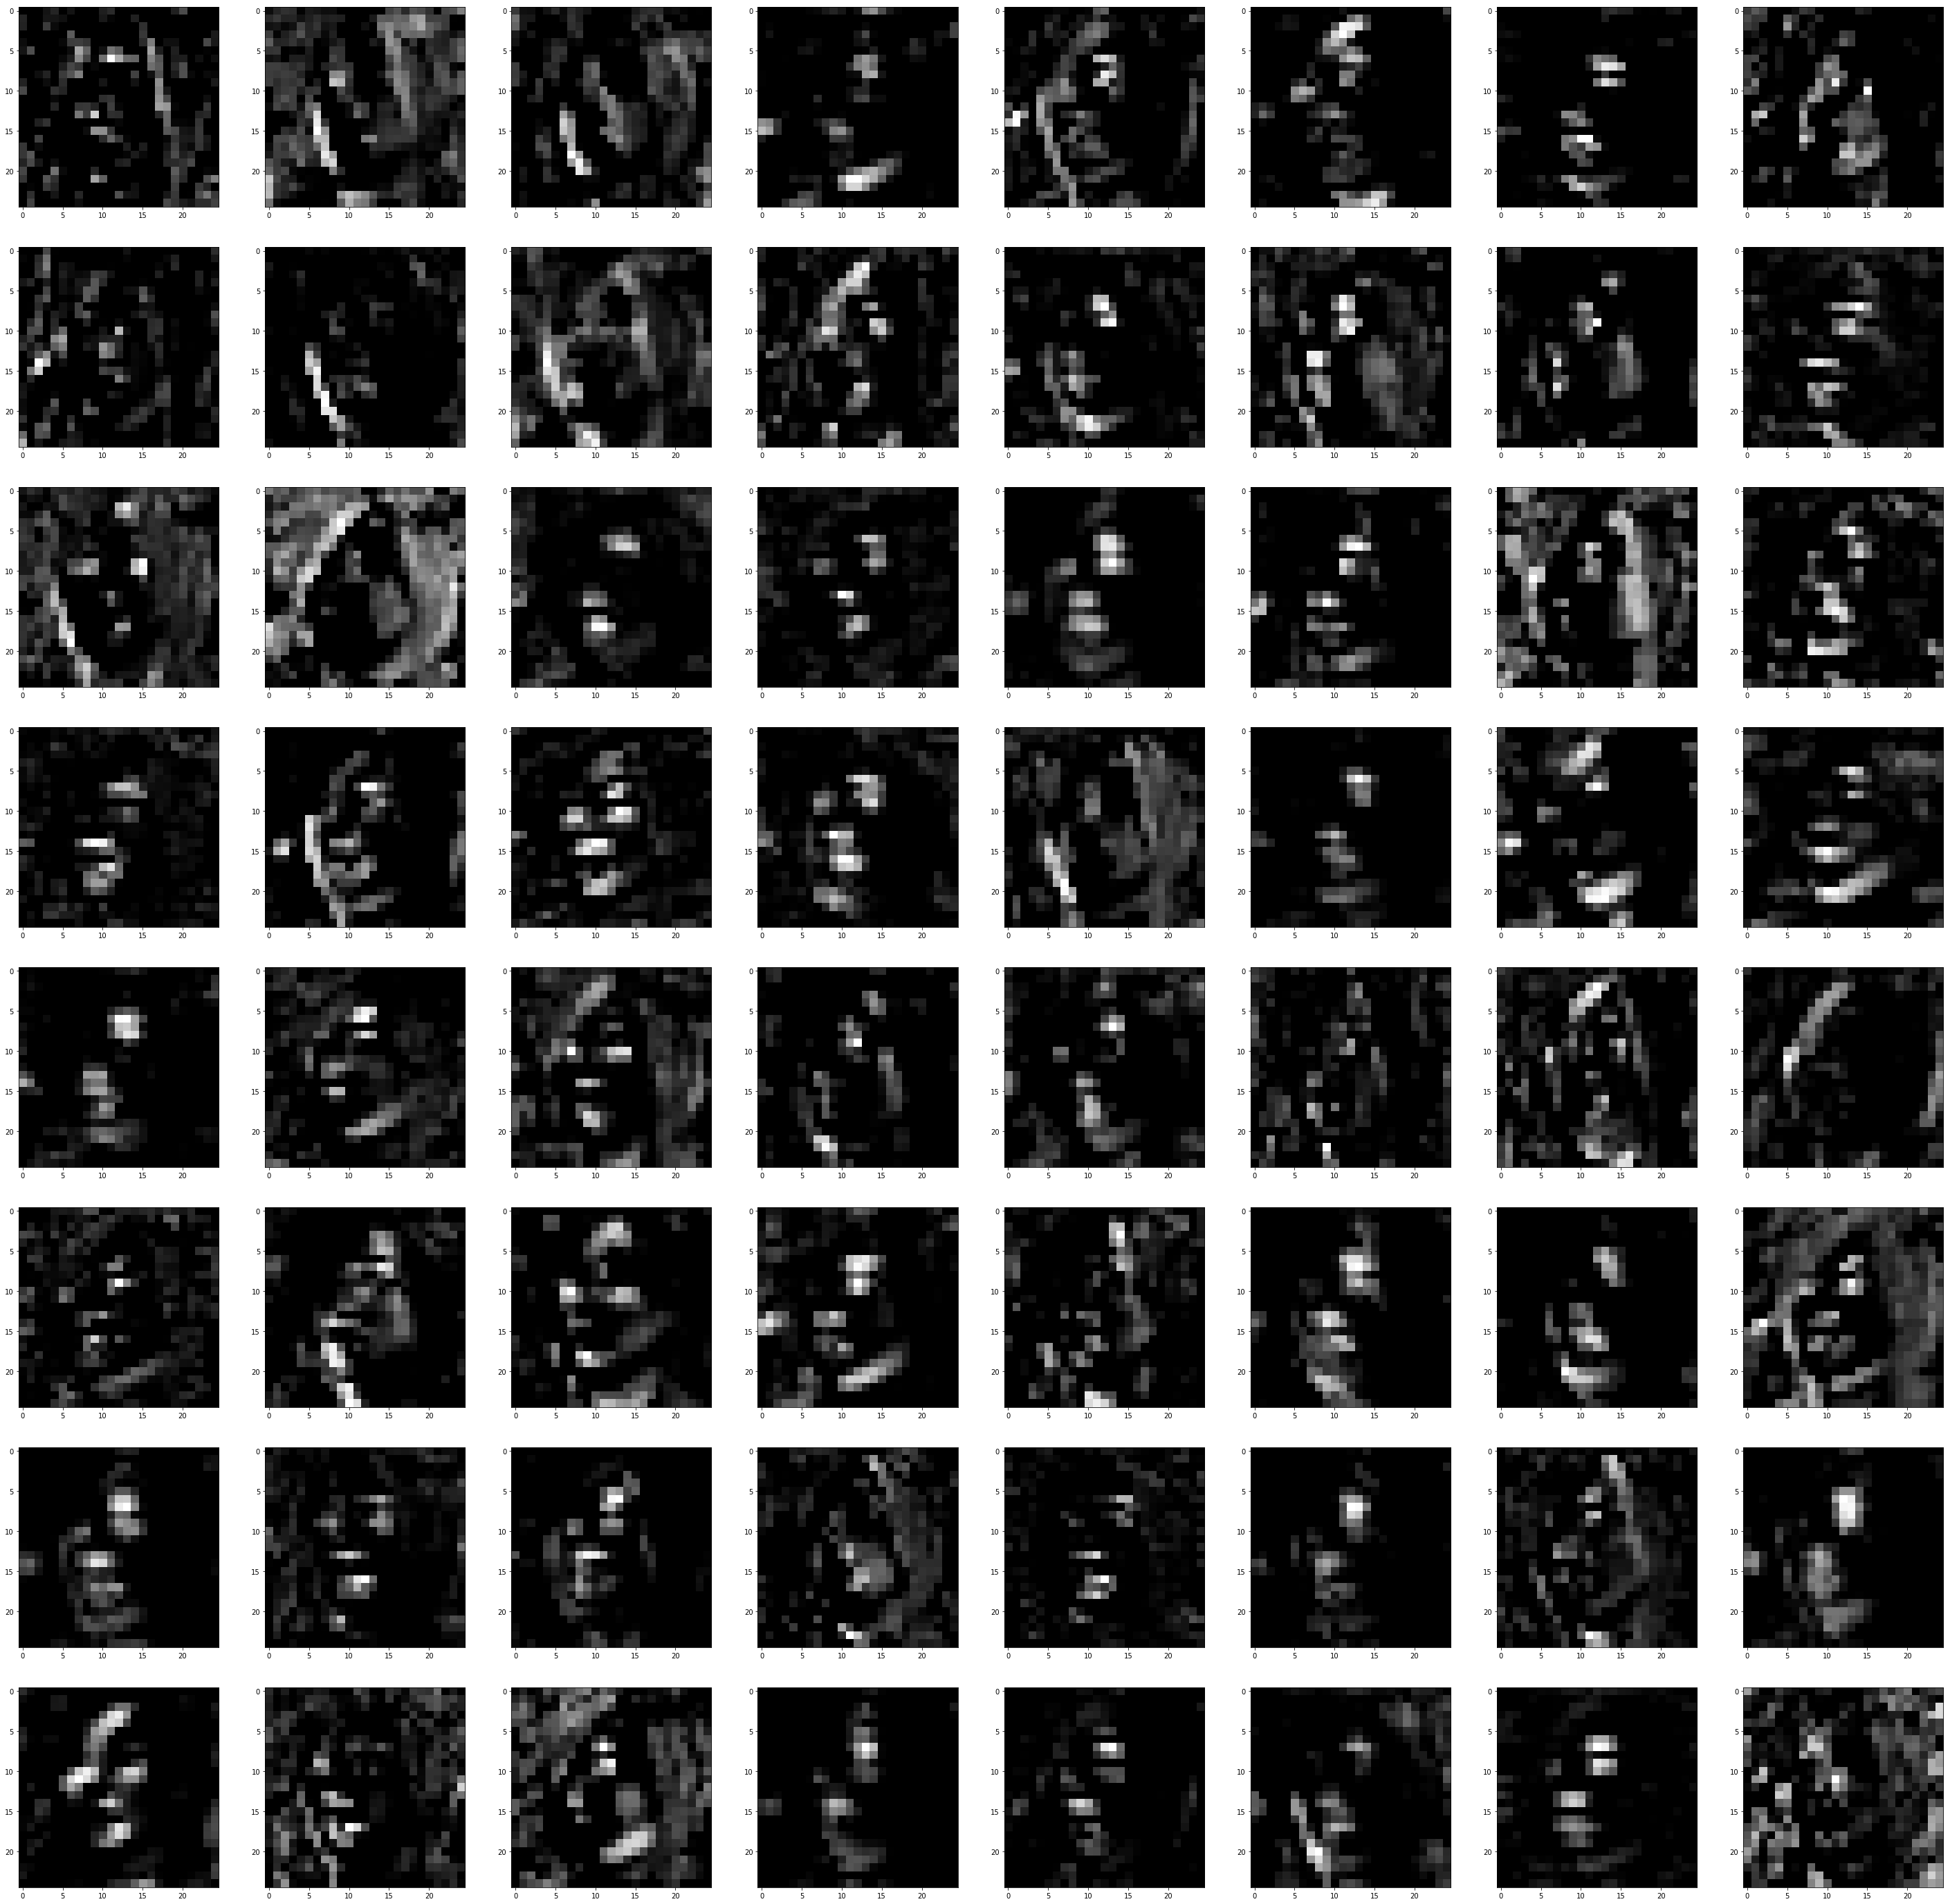

In [52]:
#conv3
show_feature(2,8,8)

(1, 224, 224)


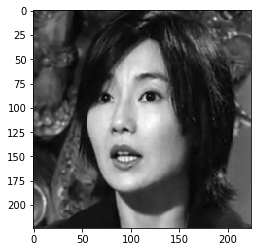

(10, 128, 11, 11)


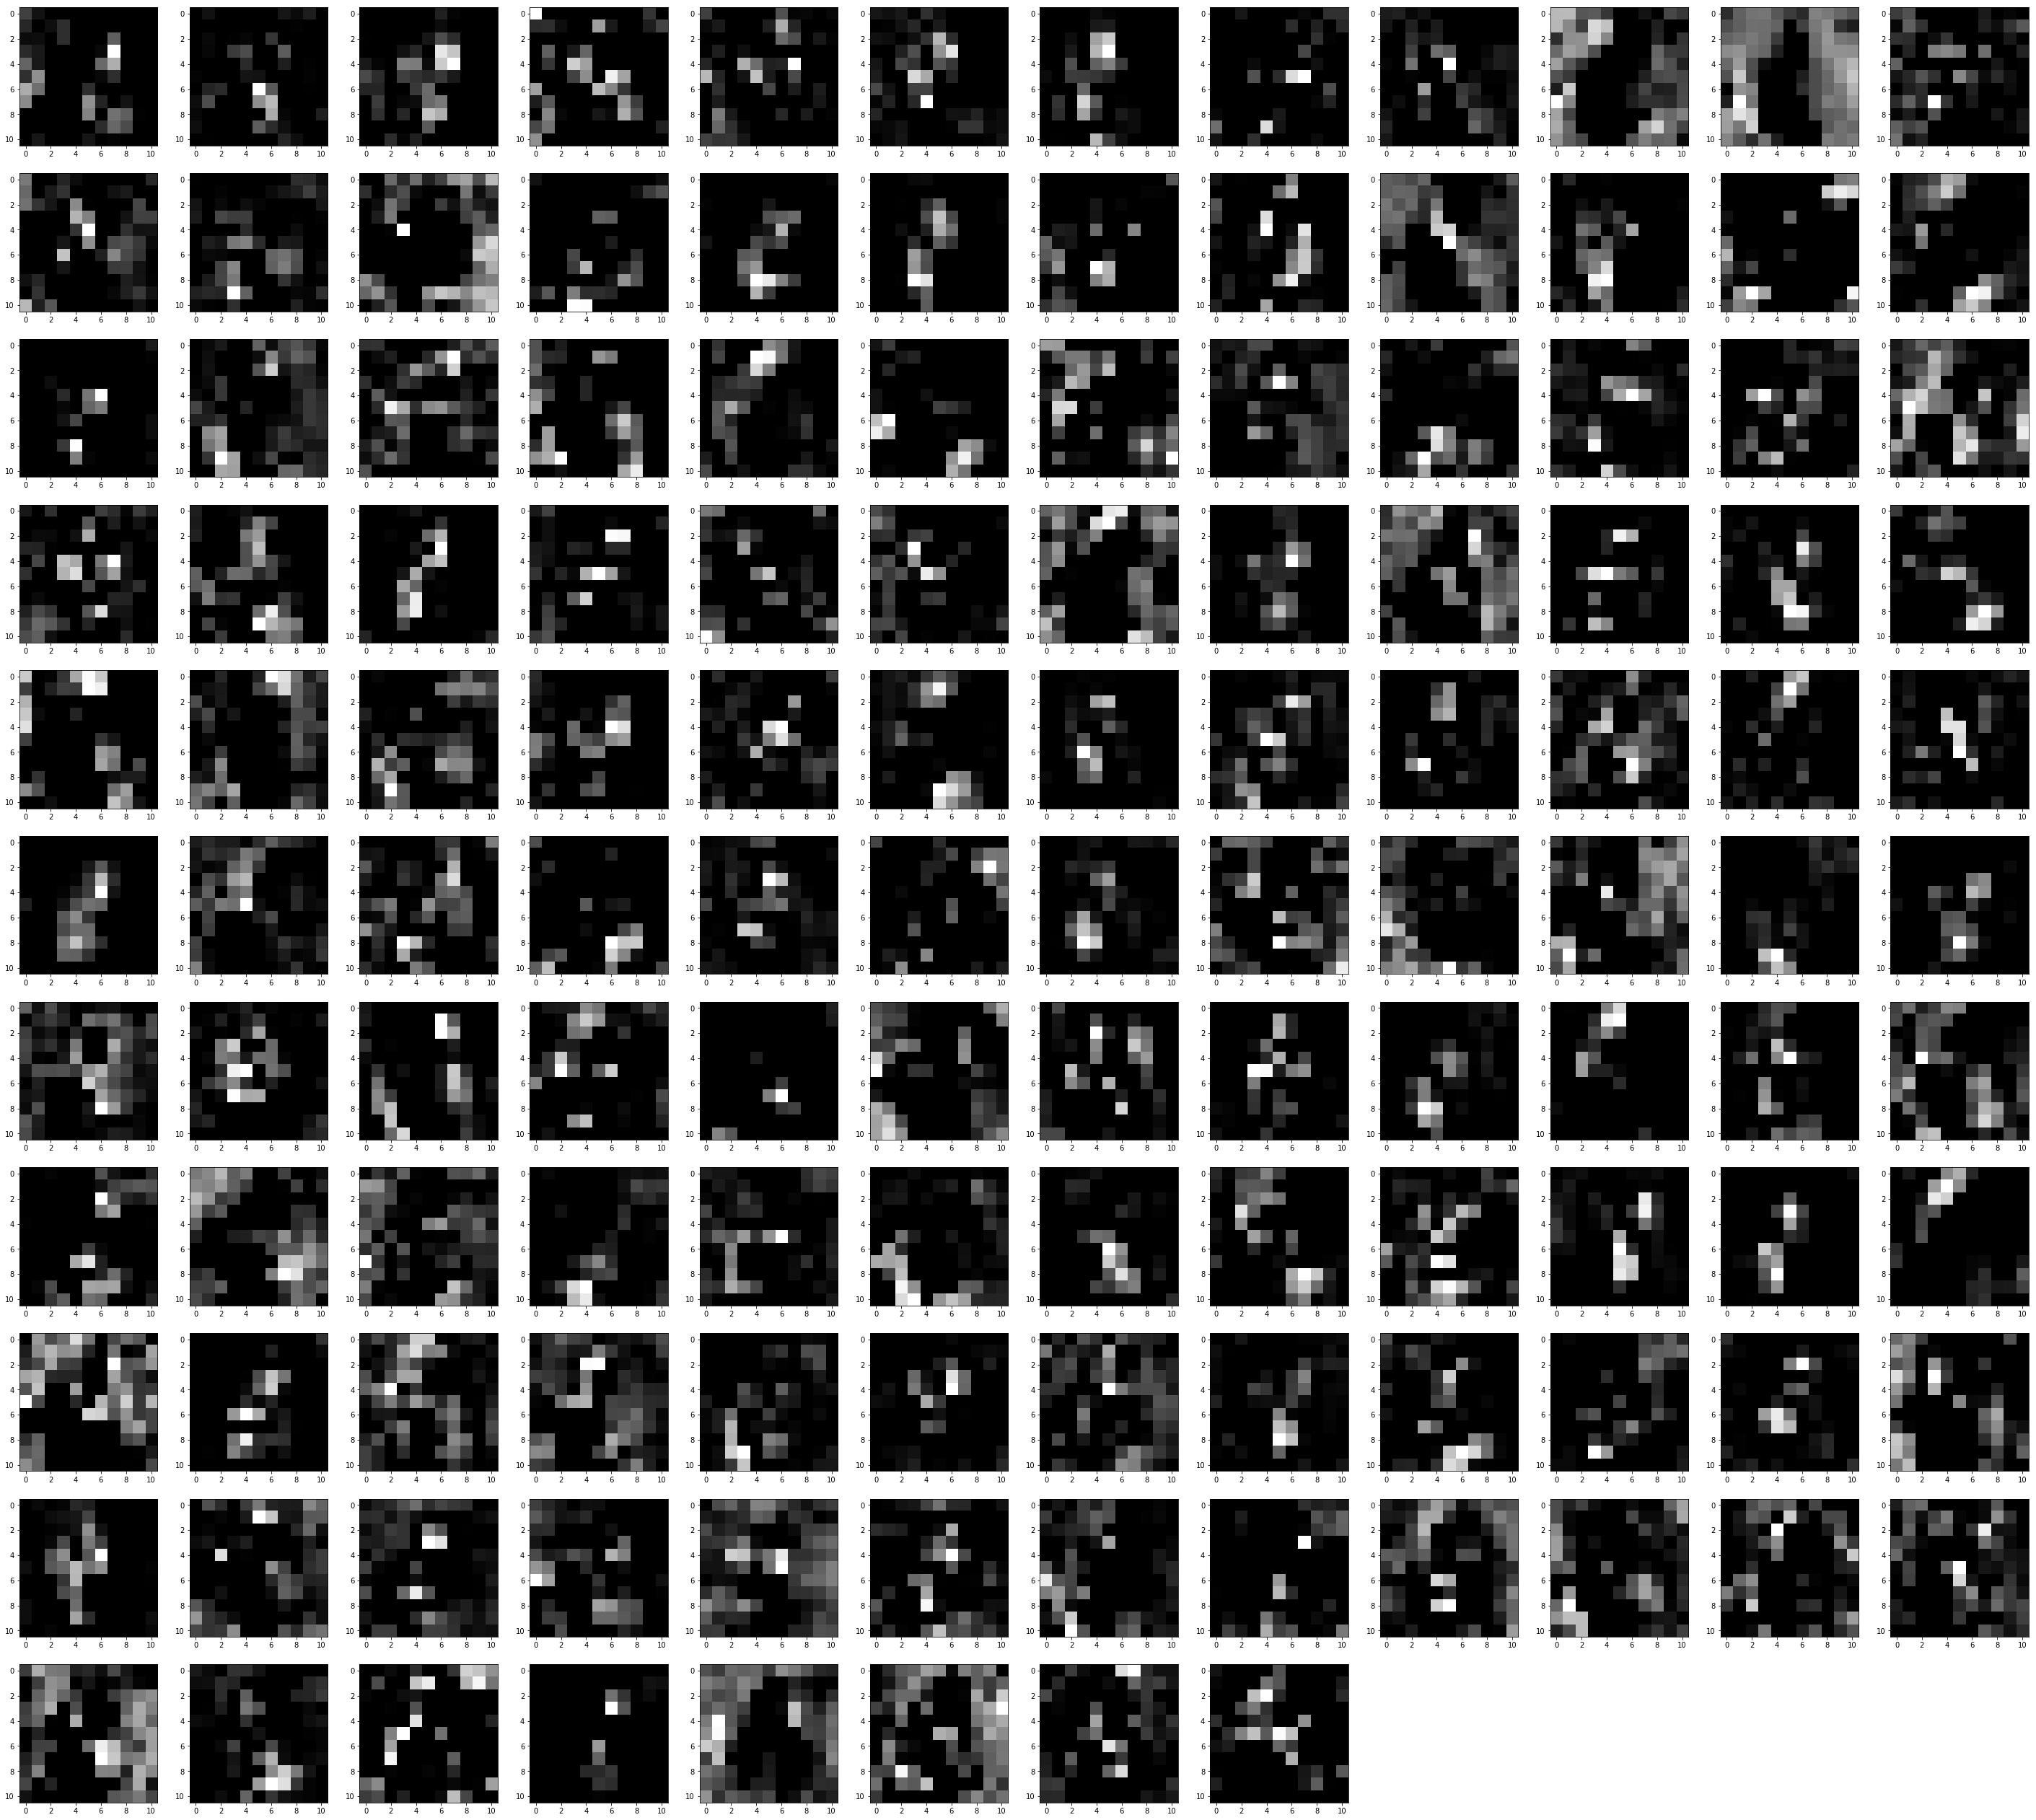

In [53]:
#conv4
show_feature(3,12,12)

Case # 1: Save the model to use it yourself for inference: You save the model, you restore it, and then you change the model to evaluation mode. This is done because you usually have BatchNorm and Dropout layers that by default are in train mode on construction:

    torch.save(model.state_dict(), filepath)

    #Later to restore:
    model.load_state_dict(torch.load(filepath))
    model.eval()
Case # 2: Save model to resume training later: If you need to keep training the model that you are about to save, you need to save more than just the model. You also need to save the state of the optimizer, epochs, score, etc. You would do it like this:

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        ...
    }
    torch.save(state, filepath)
To resume training you would do things like: state = torch.load(filepath), and then, to restore the state of each individual object, something like this:

    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
Since you are resuming training, DO NOT call model.eval() once you restore the states when loading.

Case # 3: Model to be used by someone else with no access to your code: In Tensorflow you can create a .pb file that defines both the architecture and the weights of the model. This is very handy, specially when using Tensorflow serve. The equivalent way to do this in Pytorch would be:

    torch.save(model, filepath)

    # Then later:
    model = torch.load(filepath)